# Test Gauss-Newton plane-based registration

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os

import planeslam.io as io
from planeslam.general import plot_3D_setup, color_legend
from planeslam.scan import pc_to_scan
from planeslam.registration import extract_corresponding_features, get_correspondences, residual, jacobian, so3_expmap, se3_expmap
from planeslam.geometry.util import skew

os.environ['KMP_DUPLICATE_LIB_OK']='True'

%load_ext autoreload
%autoreload 2

torch libraries not found, skipping import


Read in airsim LiDAR and pose data

In [2]:
# Read in point cloud data
binpath = os.path.join(os.getcwd(), '..', '..', 'data', 'airsim', 'blocks_60_samples_loop_closure', 'lidar', 'Drone0')
PC_data = io.read_lidar_bin(binpath)

In [3]:
# Read in ground-truth poses (in drone local frame)
posepath = os.path.join(os.getcwd(), '..', '..', 'data', 'airsim', 'blocks_60_samples_loop_closure', 'poses', 'Drone0')
drone_positions, drone_orientations = io.read_poses(posepath)

Extract planes 

In [4]:
num_scans = len(PC_data)
scans = num_scans * [None]
scans_transformed = num_scans * [None]
for i in range(num_scans):
    scans[i] = pc_to_scan(PC_data[i])

Get correspondences

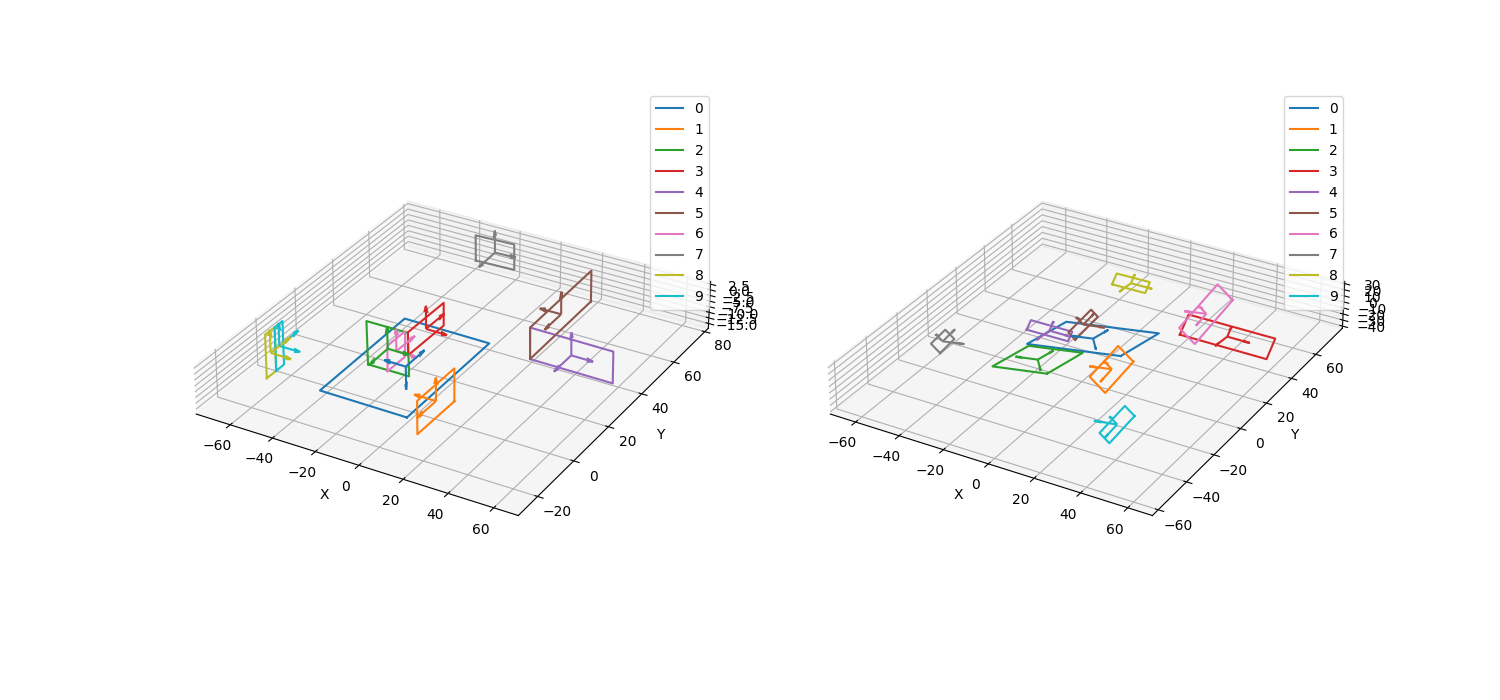

In [6]:
idx_1 = 14
idx_2 = 15

# Plot 2 scans
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax1.set_box_aspect((np.ptp(PC_data[0][:,0]), np.ptp(PC_data[0][:,1]), np.ptp(PC_data[0][:,2])))
ax2.set_box_aspect((np.ptp(PC_data[0][:,0]), np.ptp(PC_data[0][:,1]), np.ptp(PC_data[0][:,2])))
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")

scans[idx_1].plot(ax1, show_normals=True)
scans[idx_2].plot(ax2, show_normals=True)

# Color legend
color_legend(ax1, len(scans[idx_1].planes))
color_legend(ax2, len(scans[idx_2].planes))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)
array([ 0,  1,  2,  3,  5,  4,  8,  6, 10,  9,  7,  4], dtype=int64)

In [6]:
n1 = scans[idx_1].planes[0].normal
n2 = scans[idx_2].planes[0].normal
c1 = scans[idx_1].planes[0].center
c2 = scans[idx_2].planes[0].center

In [7]:
weight1 = 10
score1 = weight1 * np.dot(n1.T,n2)  # 1 to -1
score2 = np.linalg.norm(c1 - c2)  # 0 to inf

In [7]:
n = len(scans[idx_1].planes) # source P
m = len(scans[idx_2].planes) # target Q
score_mat = np.zeros((n,m))
for i in range(n):
    for j in range(m):
        n1 = scans[idx_1].planes[i].normal
        n2 = scans[idx_2].planes[j].normal
        c1 = scans[idx_1].planes[i].center
        c2 = scans[idx_2].planes[j].center
        score_mat[i,j] = np.linalg.norm(n1 - n2) + np.linalg.norm(c1 - c2)

In [8]:
score_mat

array([[ 13.93557673,  21.17820431,  13.8564419 ,  63.21204258,
         32.73904075,  34.80071098,  65.33214558,  65.32972388,
         85.02497924,  69.55225181],
       [ 25.23019233,   4.261687  ,  28.79207732,  54.35325397,
         45.13930778,  44.4943068 ,  61.42529212,  78.67278592,
         90.36350564,  58.46067004],
       [ 26.71354586,  46.95226021,  32.68634792,  73.28901497,
          8.65113232,  18.82537349,  65.88745701,  46.13261317,
         63.81945626,  98.81758068],
       [ 20.35620548,  43.86895468,  37.76764135,  62.08654167,
         18.96617206,  13.13360163,  53.81839667,  59.24973095,
         59.26299691,  97.61362873],
       [ 51.46523666,  47.49828702,  73.18413084,   4.94778819,
         70.51692532,  60.45489952,  29.4981956 , 114.14165842,
         79.55883235,  86.27379428],
       [ 50.39630409,  56.92748578,  76.01938948,  25.11386178,
         63.26574351,  50.53095329,   9.28479772, 106.94975126,
         58.40040853, 104.85123203],
       [ 2

In [9]:
np.argmin(score_mat, axis=0)

array([0, 1, 0, 4, 6, 3, 5, 8, 7, 1], dtype=int64)

In [ ]:
# Extract normals and distances
# Use idx_2 as source and idx_1 as target
correspondences = get_correspondences(scans[idx_2], scans[idx_1])
correspondences = [(0,0), (1,0), (2,1), (3,2), (4,3), (5,4), (6,5)]
n_s, d_s, n_t, d_t = extract_corresponding_features(scans[idx_2], scans[idx_1], correspondences)

In [ ]:
correspondences

In [ ]:
from planeslam.registration import so3_jacobian
from planeslam.registration import so3_residual

# Rotation estimation
R_hat = np.eye(3)

n_iters = 5
lmbda = 1e-8
mu = 1.0

for i in range(n_iters):
    r, n_q = so3_residual(R_hat, n_s, n_t)
    #print("loss: ", np.linalg.norm(r)**2)
    J = so3_jacobian(n_q)
    dw = - mu * np.linalg.inv(J.T @ J + lmbda*np.eye(3)) @ J.T @ r
    R_hat = so3_expmap(dw.flatten()) @ R_hat

r, _ = so3_residual(R_hat, n_s, n_t)
print("final rotation loss: ", np.linalg.norm(r)**2)

# Translation estimation
Rn_s = (R_hat @ n_s.reshape((3, -1), order='F'))
t_hat = np.linalg.lstsq(Rn_s.T, d_s - d_t, rcond=None)[0]

In [ ]:
R_hat

In [ ]:
t_hat

In [ ]:
from planeslam.geometry.util import quat_to_rot_mat

R_1 = quat_to_rot_mat(drone_orientations[idx_1])
R_2 = quat_to_rot_mat(drone_orientations[idx_2])
R_gt = R_2 @ R_1.T

t_gt = drone_positions[idx_2] - drone_positions[idx_1]

In [ ]:
R_gt

SO(3) optimization

In [ ]:
def so3_residual(R, n_s, n_t):
    n_q = (R @ n_s.reshape((3, -1), order='F')).reshape((-1, 1), order='F')
    return n_q - n_t, n_q

def so3_jacobian(n_q):
    N = int(len(n_q) / 3)
    J = np.empty((len(n_q), 3))

    for i in range(N):
        Rn_i =  n_q[3*i:3*i+3].flatten()
        J[3*i:3*i+3,:] = -skew(Rn_i)

    return J

In [ ]:
R = np.eye(3)

# Gauss-Newton
n_iters = 5
lmbda = 1e-8
mu = 1.0

for i in range(n_iters):
    r, n_q = so3_residual(R, n_s, n_t)
    print("loss: ", np.linalg.norm(r)**2)
    J = so3_jacobian(n_q)
    dw = - mu * np.linalg.inv(J.T @ J + lmbda*np.eye(3)) @ J.T @ r
    R = so3_expmap(dw.flatten()) @ R

In [ ]:
R

In [ ]:
R_gt

Translation estimation

In [ ]:
Rn_s = (R @ n_s.reshape((3, -1), order='F'))
np.linalg.lstsq(Rn_s.T, d_s - d_t, rcond=None)[0]

In [ ]:
t_gt

Test SE(3) Gauss-Newton registration

In [ ]:
# Initial transformation
# t = np.array([0, 1, 0])[:,None]
# u = np.array([1, 0, 0])[:,None]
# theta = 0.1
# #q = np.vstack((t, theta*u))
# q = np.random.randn(6,1)
T = np.eye(4)

# Gauss-Newton
n_iters = 20
lmbda = 0.0
mu = 1.0

for i in range(n_iters):
    r, n_q = residual(n_s, d_s, n_t, d_t, T)
    print("loss: ", np.linalg.norm(r)**2)
    J = jacobian(n_s, n_q)
    dv = -mu * np.linalg.inv(J.T @ J + lmbda*np.eye(6)) @ J.T @ r
    T = se3_expmap(dv.flatten()) @ T

# # Gauss-Newton
# n_iters = 10
# lmbda = 1e-8
# mu = 5e-1

# for i in range(n_iters):
#     r, n_q = residual(n_s, d_s, n_t, d_t, q)
#     print("loss: ", np.linalg.norm(r)**2)
#     J = jacobian(n_s, n_q)
#     dq = - mu * np.linalg.inv(J.T @ J + lmbda * np.eye(6)) @ J.T @ r

Test with two planes

In [ ]:
from planeslam.geometry.plane import BoundedPlane
from planeslam.registration import so3_expmap, se3_expmap
from planeslam.scan import Scan
import copy

V1 = np.array([[-1, 1, -1],
              [1, 1, -1],
              [1, 1, 1],
              [-1, 1, 1]])
V2 = np.array([[-1, -1, -1],
              [-1, 1, -1],
              [-1, 1, 1],
              [-1, -1, 1]])
P = Scan([BoundedPlane(V1), BoundedPlane(V2)])

# Ground-truth transformation
t = np.array([0, -0.5, 0])[:,None]
u = np.array([0, 1, 0])[:,None]
theta = np.pi/12
q = np.vstack((t, theta*u))

R = so3_expmap(q[3:].flatten())

print("t: ", t)
print("R: ", R)

In [ ]:
# P is source, Q is target
Q = copy.deepcopy(P)
Q.transform(R, t.flatten())

In [ ]:
ax = plot_3D_setup()
P.plot(ax, color='b')
Q.plot(ax, color='r')

In [ ]:
# n_s = P.normal 
# d_s = np.dot(P.normal.flatten(), P.center)
# n_t = Q.normal 
# d_t = np.dot(Q.normal.flatten(), Q.center)
correspondences = [(0,0), (1,1)]
n_s, d_s, n_t, d_t = extract_corresponding_features(P, Q, correspondences)

In [ ]:
R = np.eye(3)

# Gauss-Newton
n_iters = 5
lmbda = 1e-8
mu = 1.0

for i in range(n_iters):
    r, n_q = so3_residual(R, n_s, n_t)
    print("loss: ", np.linalg.norm(r)**2)
    J = so3_jacobian(n_q)
    dw = - mu * np.linalg.inv(J.T @ J + lmbda*np.eye(3)) @ J.T @ r
    R = so3_expmap(dw.flatten()) @ R

In [ ]:
R

In [ ]:
# Initial transformation
# t = np.array([0, 1, 0])[:,None]
# u = np.array([1, 0, 0])[:,None]
# theta = 0.1
# q = np.vstack((t, theta*u))
T = np.eye(4)

# Gauss-Newton
n_iters = 20
lmbda = 1e-8
mu = 0.5

for i in range(n_iters):
    r, n_q = residual(n_s, d_s, n_t, d_t, T)
    print("loss: ", np.linalg.norm(r)**2)
    J = jacobian(n_s, n_q)
    dv = - mu * np.linalg.inv(J.T @ J + lmbda*np.eye(6)) @ J.T @ r
    T = se3_expmap(dv.flatten()) @ T

In [ ]:
# Extract R and t from q
# t_est = q[:3]
# R_est = expmap(q[3:].flatten())
# print("t_est: ", t_est)
# print("R_est: ", R_est)

# Apply transformation to source
P_T = copy.copy(P)
P_T.transform(R, t.flatten())

In [ ]:
plot_P = np.vstack((np.eye(3), -np.eye(3)))
ax = plot_3D_setup(P=plot_P)
P_T.plot(ax, color='b')
Q.plot(ax, color='r')

Rotation only

In [ ]:
from planeslam.geometry.util import skew
from planeslam.registration import so3_expmap

In [ ]:
def residual(R, n_s, n_t):
    n_q = (R @ n_s.reshape((3, -1), order='F')).reshape((-1, 1), order='F')
    return n_q - n_t, n_q

def jacobian(n_q):
    N = int(len(n_q) / 3)

    J = np.empty((3*N,3))
    for i in range(N):
        Rn_i = n_q[3*i:3*i+3].flatten()
        J[3*i:3*i+3,:] = -skew(Rn_i)
    
    return J

In [ ]:
n_s = np.array([1,2,3, 1,2,1, -1,1,2])[:,None]

R_gt = so3_expmap([0, 0.5, 0])
n_t = (R_gt @ n_s.reshape((3, -1), order='F')).reshape((-1, 1), order='F')

In [ ]:
R = np.eye(3)
mu = 1.0
lmbda = 1e-5

for i in range(10):
    r, n_q = residual(R, n_s, n_t)
    print("loss: ", np.linalg.norm(r)**2)
    J = jacobian(n_q)
    dw = -mu * np.linalg.inv(J.T @ J + lmbda*np.eye(3)) @ J.T @ r
    R = so3_expmap(dw.flatten()) @ R

In [ ]:
R

In [ ]:
R_gt